In [9]:
# --- Setup: fast, reproducible, quiet ---
suppressPackageStartupMessages({
  library(readr)
  library(dplyr)
  library(tidyr)
  library(stringr)
  library(lubridate)
  library(purrr)
  library(ggplot2)
  library(forcats)
})

# Keep displays readable
options(dplyr.summarise.inform = FALSE)
options(width = 120)
options(pillar.sigfig = 7)

In [10]:
# --- Load CSV efficiently with robust typing ---
PATH <- "/content/region_05.csv"  # <- your dataset

# 1) Quick peek to infer intent and potential dtypes (cheap)
sample <- read_csv(PATH, n_max = 1000, show_col_types = FALSE, progress = FALSE)
# Identify candidate datetime cols by name or pattern
likely_datetime_cols <- names(sample)[
  vapply(names(sample), function(c)
    any(str_detect(tolower(c), "(date|time|dt|timestamp)")),
    logical(1))
]

In [11]:
# Identify obvious numeric candidates (heuristic)
# (let readr infer, then optimize afterward; don't force floats yet)
# We'll pass default guessing to readr, then optimize afterward.

# 2) Full read (single pass)
df <- read_csv(
  PATH,
  show_col_types = FALSE,
  progress = FALSE
)

cat("Loaded shape:", nrow(df), ncol(df), "\n")
print(head(df, 3))

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”


Loaded shape: 14498 135 
# A tibble: 3 × 135
       eventid iyear imonth  iday approxdate extended resolution country country_txt region region_txt   provstate city 
         <dbl> <dbl>  <dbl> <dbl> <chr>         <dbl> <date>       <dbl> <chr>        <dbl> <chr>        <chr>     <chr>
1 197001000001  1970      1     0 NA                0 NA             160 Philippines      5 Southeast A… Tarlac    Unkn…
2 197001210001  1970      1    21 NA                0 NA             160 Philippines      5 Southeast A… Metropol… Quez…
3 197001310001  1970      1    31 NA                0 NA             160 Philippines      5 Southeast A… Tarlac    Bamb…
# ℹ 122 more variables: latitude <dbl>, longitude <dbl>, specificity <dbl>, vicinity <dbl>, location <chr>,
#   summary <chr>, crit1 <dbl>, crit2 <dbl>, crit3 <dbl>, doubtterr <dbl>, alternative <dbl>, alternative_txt <chr>,
#   multiple <dbl>, success <dbl>, suicide <dbl>, attacktype1 <dbl>, attacktype1_txt <chr>, attacktype2 <dbl>,
#   attacktype

In [12]:
# Parse likely datetime columns if present (guarded)
if (length(likely_datetime_cols) > 0) {
  for (cc in likely_datetime_cols) {
    if (cc %in% names(df)) {
      # Try multiple common formats; keep NA on failure
      df[[cc]] <- suppressWarnings(parse_date_time(df[[cc]], orders = c(
        "Ymd HMS", "Ymd HM", "Ymd H", "Ymd",
        "mdY HMS", "mdY HM", "mdY H", "mdY",
        "dmy HMS", "dmy HM", "dmy H", "dmy"
      )))
    }
  }
}


In [13]:
# --- Type & NA optimization ---

# 2.1 Downcast numeric columns to reduce memory
num_cols <- names(df)[vapply(df, function(x) is.numeric(x) || is.integer(x), logical(1))]
if (length(num_cols) > 0) {
  # Ensure numeric where possible (coerce errors to NA)
  for (c in num_cols) {
    df[[c]] <- suppressWarnings(as.numeric(df[[c]]))
  }
}

In [14]:
# 2.2 Convert low-cardinality object columns to category (fast groupbys)
obj_cols <- names(df)[vapply(df, function(x) is.character(x) || is.factor(x), logical(1))]
for (c in obj_cols) {
  # Only category-encode when it's beneficial (unique < 30% of rows and >1)
  unq <- n_distinct(df[[c]], na.rm = TRUE)
  if (!is.na(unq) && unq > 1 && unq < 0.3 * nrow(df)) {
    df[[c]] <- as.factor(df[[c]])
  }
}


In [19]:
# --- 2.3 Missing Values Handling (final robust version) ---

# Text columns: fill missing with "Unknown"
for (col in c("country_txt", "region_txt", "provstate", "city")) {
  if (col %in% names(df)) {
    if (is.factor(df[[col]])) {
      # Only add the new category if it isn't already there
      if (!("Unknown" %in% levels(df[[col]]))) {
        df[[col]] <- fct_expand(df[[col]], "Unknown")
      }
      df[[col]] <- fct_na_value_to_level(df[[col]], level = "Unknown")
      df[[col]][is.na(df[[col]])] <- "Unknown"
      df[[col]] <- droplevels(df[[col]])
    } else {
      df[[col]] <- replace_na(df[[col]], "Unknown")
    }
  }
}

# Numeric columns: fill missing with 0 (after coercing invalid entries)
for (col in c("nkill", "nwound", "nperps", "property_damage_usd")) {
  if (col %in% names(df)) {
    df[[col]] <- suppressWarnings(as.numeric(df[[col]]))
    df[[col]] <- replace_na(df[[col]], 0)
  }
}
# Temporal columns: ensure numeric, fill safe defaults, and build event_date
for (col in c("iyear", "imonth", "iday")) {
  if (col %in% names(df)) {
    df[[col]] <- suppressWarnings(as.numeric(df[[col]]))
  }
}

if (all(c("iyear", "imonth", "iday") %in% names(df))) {
  # year is mandatory
  df <- df %>% filter(!is.na(iyear))
  df$imonth <- replace_na(df$imonth, 1)
  df$iday   <- replace_na(df$iday, 1)

  # Construct a safe datetime column (clip to avoid invalid dates)
  clip_month <- function(x) pmin(pmax(x, 1), 12)
  clip_day   <- function(x) pmin(pmax(x, 1), 28)

  df$event_date <- suppressWarnings(
    make_date(
      year  = as.integer(df$iyear),
      month = as.integer(clip_month(df$imonth)),
      day   = as.integer(clip_day(df$iday))
    )
  )
}
cat("✅ Missing-value handling complete. Current shape:", nrow(df), ncol(df), "\n")
if (all(c("country_txt", "region_txt") %in% names(df))) {
  print(head(df[, c("country_txt", "region_txt")], 5))
}


✅ Missing-value handling complete. Current shape: 14498 136 
# A tibble: 5 × 2
  country_txt region_txt    
  <fct>       <chr>         
1 Philippines Southeast Asia
2 Philippines Southeast Asia
3 Philippines Southeast Asia
4 Philippines Southeast Asia
5 Philippines Southeast Asia


In [20]:
# --- Quick validation ---
missing_summary <- sort(colSums(is.na(df)), decreasing = TRUE)
cat("Top missing columns:\n")
print(head(missing_summary, 10))

cat("\nSample of dtypes:\n")
dtypes_head <- tibble(
  column = names(df),
  class  = vapply(df, function(x) paste(class(x), collapse = ","), character(1))
) %>% slice_head(n = 20)
print(dtypes_head)

Top missing columns:
       gsubname3        weaptype4    weaptype4_txt     weapsubtype4 weapsubtype4_txt         nwoundte        gsubname2 
           14498            14498            14498            14498            14498            14498            14495 
      claimmode3   claimmode3_txt       claimmode2 
           14486            14486            14477 

Sample of dtypes:
# A tibble: 20 × 2
   column      class         
   <chr>       <chr>         
 1 eventid     numeric       
 2 iyear       numeric       
 3 imonth      numeric       
 4 iday        numeric       
 5 approxdate  POSIXct,POSIXt
 6 extended    numeric       
 7 resolution  Date          
 8 country     numeric       
 9 country_txt factor        
10 region      numeric       
11 region_txt  character     
12 provstate   factor        
13 city        character     
14 latitude    numeric       
15 longitude   numeric       
16 specificity numeric       
17 vicinity    numeric       
18 location    character   

In [21]:
# basic sanity on numerics (no negative casualties, etc., if applicable)
for (col in c("nkill", "nwound")) {
  if (col %in% names(df)) {
    bad <- sum(df[[col]] < 0, na.rm = TRUE)
    if (bad > 0) {
      message(sprintf("WARNING: %s negative values in %s (setting to NA).", bad, col))
      df[[col]][df[[col]] < 0] <- NA_real_
    }
  }
}

In [22]:
# --- 💾 Save cleaned dataset for reuse and visualization ---

cleaned_path <- "region_05_clean.csv"
write_csv(df, cleaned_path)
cat(sprintf("Cleaned dataset saved successfully as '%s'\n", cleaned_path))

# Optional: Reload to verify integrity
df_viz <- read_csv(cleaned_path, show_col_types = FALSE)
cat("Reloaded dataset for visualization. Shape:", nrow(df_viz), ncol(df_viz), "\n")

# Quick check to confirm data consistency
print(head(df_viz, 5))


Cleaned dataset saved successfully as 'region_05_clean.csv'
Reloaded dataset for visualization. Shape: 14498 136 
# A tibble: 5 × 136
      eventid iyear imonth  iday approxdate extended resolution country country_txt region region_txt     provstate     
        <dbl> <dbl>  <dbl> <dbl> <dttm>        <dbl> <date>       <dbl> <chr>        <dbl> <chr>          <chr>         
1 1.970010e11  1970      1     0 NA                0 NA             160 Philippines      5 Southeast Asia Tarlac        
2 1.970012e11  1970      1    21 NA                0 NA             160 Philippines      5 Southeast Asia Metropolitan …
3 1.970013e11  1970      1    31 NA                0 NA             160 Philippines      5 Southeast Asia Tarlac        
4 1.970030e11  1970      3     0 NA                0 NA             160 Philippines      5 Southeast Asia Metropolitian…
5 1.970032e11  1970      3    24 NA                0 NA             160 Philippines      5 Southeast Asia Pampanga      
# ℹ 124 more variab

In [27]:

# --- 📊 Descriptive Statistics (using cleaned dataset) ---

# Load the cleaned dataset (if not already loaded)
# (In R this is already loaded as df_viz; keeping the guard for parity)
if (!exists("df_viz")) {
  df_viz <- read_csv("region_05_clean.csv", show_col_types = FALSE)
  cat("🔁 Clean dataset reloaded from 'region_05_clean.csv'\n")
}
# Select only numeric columns for descriptive stats
num_for_stats <- names(df_viz)[vapply(df_viz, is.numeric, logical(1))]

# Compute descriptive statistics including quartiles and median
desc_list <- lapply(num_for_stats, function(col) {
  x <- df_viz[[col]]
  tibble::tibble(
    variable = col,
    count = sum(!is.na(x)),
    mean  = mean(x, na.rm = TRUE),
    std   = sd(x, na.rm = TRUE),
    min   = suppressWarnings(min(x, na.rm = TRUE)),
    `25%` = quantile(x, 0.25, na.rm = TRUE, names = FALSE),
    median = median(x, na.rm = TRUE),
    `75%` = quantile(x, 0.75, na.rm = TRUE, names = FALSE),
    max   = suppressWarnings(max(x, na.rm = TRUE))
  )
})

desc <- bind_rows(desc_list)
desc <- desc %>% mutate(across(-variable, ~ round(., 3))) %>%
  select(variable, count, mean, std, min, `25%`, median, `75%`, max)

cat("✅ Descriptive statistics computed on cleaned dataset:\n")
print(desc)



✅ Descriptive statistics computed on cleaned dataset:
# A tibble: 74 × 9
   variable    count         mean         std          min       `25%`      median       `75%`         max
   <chr>       <dbl>        <dbl>       <dbl>        <dbl>       <dbl>       <dbl>       <dbl>       <dbl>
 1 eventid     14498 2.008340e+11 1.063743e+9  1.970010e11 2.004011e11 2.013032e11 2.016052e11 2.020123e11
 2 iyear       14498 2.008274e+ 3 1.0638  e+1  1.97    e 3 2.004   e 3 2.013   e 3 2.016   e 3 2.02    e 3
 3 imonth      14498 6.403   e+ 0 3.345   e+0  0           4       e 0 6       e 0 9       e 0 1.2     e 1
 4 iday        14498 1.5522  e+ 1 8.762   e+0  0           8       e 0 1.5     e 1 2.3     e 1 3.1     e 1
 5 extended    14498 4.4     e- 2 2.05    e-1  0           0           0           0           1       e 0
 6 country     14498 1.65502 e+ 2 3.4243  e+1  3.1     e 1 1.600000e 2 1.600000e 2 2.05    e 2 3.47    e 2
 7 region      14498 5       e+ 0 0            5       e 0 5       e 0 

In [28]:
# --- Example: yearly incidents & casualties (fast groupby) ---
# Works if these columns exist; otherwise skip/rename to your schema
if ("iyear" %in% names(df)) {
  if ("nkill" %in% names(df)) {
    fatalities_expr <- expr(sum(nkill, na.rm = TRUE))
  } else {
    fatalities_expr <- expr(n())
  }
  if ("nwound" %in% names(df)) {
    injuries_expr <- expr(sum(nwound, na.rm = TRUE))
  } else {
    injuries_expr <- expr(n())
  }

  yearly <- df %>%
    group_by(iyear) %>%
    summarise(
      incidents  = n(),
      fatalities = !!fatalities_expr,
      injuries   = !!injuries_expr,
      .groups = "drop"
    ) %>%
    arrange(iyear)

  print(head(yearly))
}

# A tibble: 6 × 4
  iyear incidents fatalities injuries
  <dbl>     <int>      <dbl>    <dbl>
1  1970        10         41       13
2  1971         6          2       10
3  1972        15          3        1
4  1973         2          0        8
5  1974         3          5        0
6  1975         7          1       48


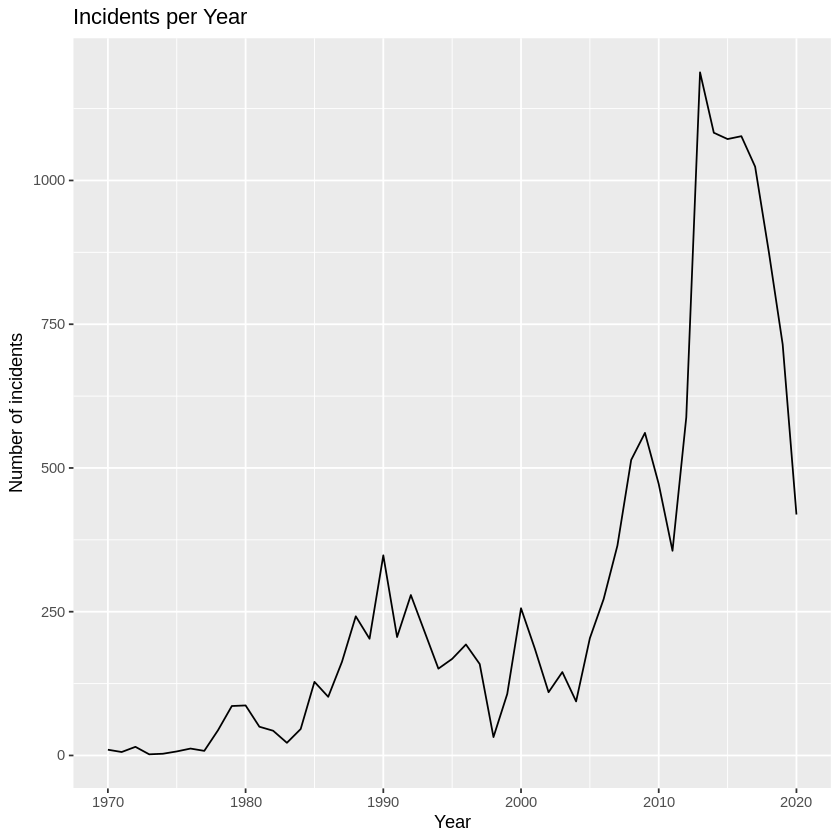

In [29]:
# --- Plot: yearly incidents (only if yearly exists) ---
if (exists("yearly") && nrow(yearly) > 0) {
  gg <- ggplot(yearly, aes(x = iyear, y = incidents)) +
    geom_line() +
    labs(title = "Incidents per Year",
         x = "Year", y = "Number of incidents")
  print(gg)
}

# A tibble: 24 × 2
   month      count
   <date>     <int>
 1 1970-01-01     3
 2 1970-03-01     2
 3 1970-04-01     2
 4 1970-06-01     2
 5 1970-11-01     1
 6 1971-02-01     1
 7 1971-03-01     3
 8 1971-09-01     2
 9 1972-01-01     1
10 1972-03-01     2
# ℹ 14 more rows


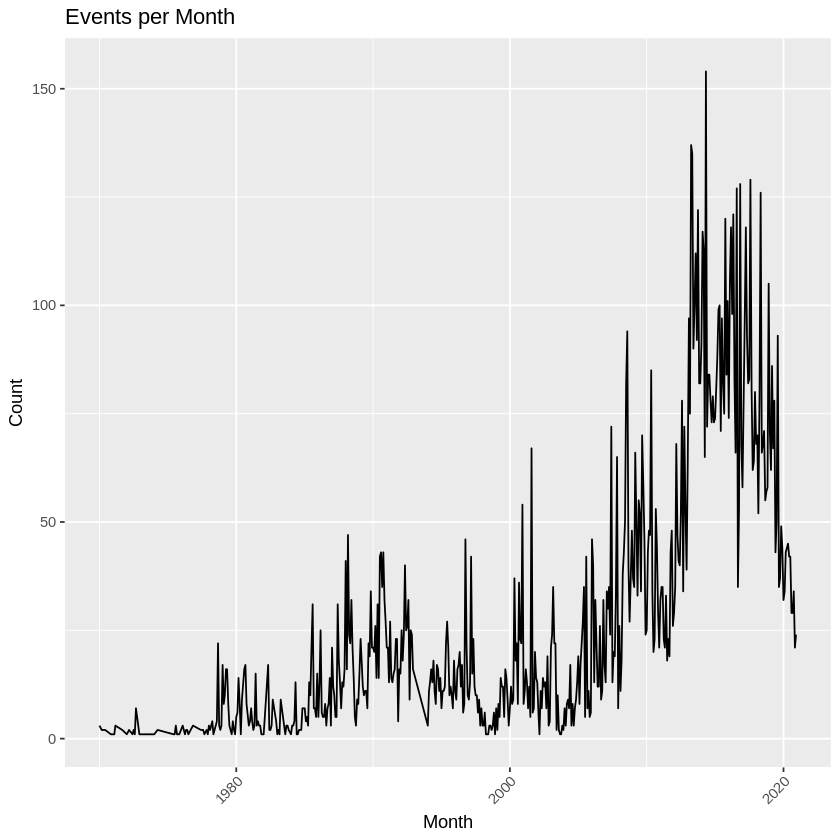

In [30]:
# 2) Events per MONTH (time series)
# -----------------------------
if ("event_date" %in% names(df) && any(!is.na(df$event_date))) {
  monthly <- df %>%
    mutate(event_date = as_date(event_date)) %>%
    filter(!is.na(event_date)) %>%
    mutate(month = floor_date(event_date, unit = "month")) %>%
    count(month, name = "count") %>%
    arrange(month)

  print(head(monthly, 24))

  gg2 <- ggplot(monthly, aes(x = month, y = count)) +
    geom_line() +
    labs(title = "Events per Month",
         x = "Month", y = "Count") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  print(gg2)
}